# Support vector machine using LinearKernel and gaussianKernel


In [65]:

import os
import scipy as sp
import numpy as np
import scipy.io
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def linearKernel(x1, x2):
    #simple linear SVM with Q^T.X as Z
    return np.dot(x1, x2)
    

In [67]:
def gaussianKernel(x1, x2, sigma):
    sim = np.exp(-np.sum((x1 - x2) ** 2) / (2 * (sigma ** 2)))
    return sim

In [126]:
def svmTrain(X, Y, C, kernelFunction, tol=1e-3, max_passes=5, args=()):
    '''
    Trains an SVM classifier using a  simplified version of the Sequential minimal optimization(SMO) algorithm
    
     C : float
        The standard SVM regularization parameter.
    kernelFunction : func
        A function handle which computes the kernel. The function should accept two vectors as
        inputs, and returns a scalar as output.
    tol : float, optional
        Tolerance value used for determining equality of floating point numbers.
    max_passes : int, optional
        Controls the number of iterations over the dataset (without changes to alpha)
        before the algorithm quits.
    args : tuple
        Extra arguments required for the kernel function, such as the sigma parameter for a
        Gaussian kernel.
    '''
    # make sure data is signed int
    Y = Y.astype(int)
    # Dataset size parameters
    m, n = X.shape

    passes = 0
    E = np.zeros(m)
    alphas = np.zeros(m)
    b = 0

    # Map 0 to -1
    Y[Y == 0] = -1

    # Pre-compute the Kernel Matrix since our dataset is small
    # (in practice, optimized SVM packages that handle large datasets
    # gracefully will **not** do this)

    # We have implemented the optimized vectorized version of the Kernels here so
    # that the SVM training will run faster
    if kernelFunction.__name__ == 'linearKernel':
        # Vectorized computation for the linear kernel
        # This is equivalent to computing the kernel on every pair of examples
        K = linearKernel(X, X.T)
    elif kernelFunction.__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        
        X2 = np.sum(X**2, axis=1)
        K = X2 + X2[:, None] - 2 * np.dot(X, X.T)

        if len(args) > 0:
            K /= 2*args[0]**2

        K = np.exp(-K)
    else:
        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i, j] = kernelFunction(X[i, :], X[j, :])
                K[j, i] = K[i, j]

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(m):
            E[i] = b + np.sum(alphas * Y * K[:, i]) - Y[i]

            if (Y[i]*E[i] < -tol and alphas[i] < C) or (Y[i]*E[i] > tol and alphas[i] > 0):
                # select the alpha_j randomly
                j = np.random.choice(list(range(i)) + list(range(i+1, m)), size=1)[0]

                E[j] = b + np.sum(alphas * Y * K[:, j]) - Y[j]

                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]

                if Y[i] == Y[j]:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                else:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])

                if L == H:
                    continue

                eta = 2 * K[i, j] - K[i, i] - K[j, j]

                # objective function positive definite, there will be a minimum along the direction
                # of linear equality constrain, and eta will be greater than zero
                # we are actually computing -eta here (so we skip of eta >= 0)
                if eta >= 0:
                    continue

                alphas[j] -= Y[j] * (E[i] - E[j])/eta
                alphas[j] = max(L, min(H, alphas[j]))

                if abs(alphas[j] - alpha_j_old) < tol:
                    alphas[j] = alpha_j_old
                    continue
                alphas[i] += Y[i]*Y[j]*(alpha_j_old - alphas[j])

                b1 = b - E[i] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[i, j]

                b2 = b - E[j] - Y[i]*(alphas[i] - alpha_i_old) * K[i, j] \
                     - Y[j] * (alphas[j] - alpha_j_old) * K[j, j]

                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2)/2

                num_changed_alphas += 1
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0

    idx = alphas > 0
    model = {'X': X[idx, :],
             'y': Y[idx],
             'kernelFunction': kernelFunction,
             'b': b,
             'args': args,
             'alphas': alphas[idx],
             'w': np.dot(alphas * Y, X)}
    return model

    


In [110]:
def svmPredict(model, X):
    if X.ndim == 1:
        X = X[np.newaxis, :]

    m = X.shape[0]
    p = np.zeros(m)
    pred = np.zeros(m)

    if model['kernelFunction'].__name__ == 'linearKernel':
        # we can use the weights and bias directly if working with the linear kernel
        p = np.dot(X, model['w']) + model['b']
    elif model['kernelFunction'].__name__ == 'gaussianKernel':
        # vectorized RBF Kernel
        # This is equivalent to computing the kernel on every pair of examples
        X1 = np.sum(X**2, 1)
        X2 = np.sum(model['X']**2, 1)
        K = X2 + X1[:, None] - 2 * np.dot(X, model['X'].T)

        if len(model['args']) > 0:
            K /= 2*model['args'][0]**2

        K = np.exp(-K)
        p = np.dot(K, model['alphas']*model['y']) + model['b']
    else:
        # other non-linear kernel
        for i in range(m):
            predictions = 0
            for j in range(model['X'].shape[0]):
                predictions += model['alphas'][j] * model['y'][j] \
                               * model['kernelFunction'](X[i, :], model['X'][j, :])
            p[i] = predictions

    pred[p >= 0] = 1
    return pred

In [108]:
def plotData(X, y, grid=False):
    # Plot Examples
    pos = y == 1
    neg = y == 0

    plt.plot(X[pos, 0], X[pos, 1], 'X', mew=1, ms=10, mec='k')
    plt.plot(X[neg, 0], X[neg, 1], 'o', mew=1, mfc='y', ms=10, mec='k')
    plt.grid(grid)


In [112]:
def visualizeBoundaryLinear(X, y, model):
    w, b = model['w'], model['b']
    xp = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    yp = -(w[0] * xp + b)/w[1]

    plotData(X, y)
    plt.plot(xp, yp, '-b')
     

In [114]:
def visualizeBoundary(X, y, model):
    plotData(X, y)

    # make classification predictions over a grid of values
    x1plot = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    x2plot = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x1plot, x2plot)

    vals = np.zeros(X1.shape)
    for i in range(X1.shape[1]):
        this_X = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = svmPredict(model, this_X)

    plt.contour(X1, X2, vals, colors='y', linewidths=2)
    plt.pcolormesh(X1, X2, vals, cmap='YlGnBu', alpha=0.25, edgecolors='None', lw=0)
    plt.grid(False)

In [99]:
dataset_1 = scipy.io.loadmat('Data/ex6data1.mat')
dataset_2 = scipy.io.loadmat('Data/ex6data2.mat')


In [93]:
X_1 = dataset_1['X']
y_1 = dataset_1['y'].reshape(-1) #reshape(1,-1) one row and -1 means numpy will find columns by itself by setting it reshape(-1) based on it's element numpy will implicitly infer new shape for it

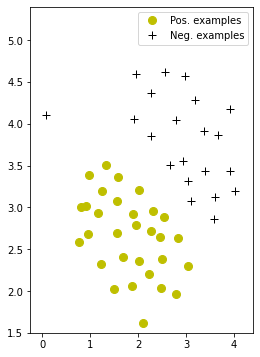

In [94]:
plt.figure(figsize=(4, 6))
plt.plot(X_1[y_1 == 0].T[0], X_1[y_1 == 0].T[1], 'yo', ms=8, label='Pos. examples')
plt.plot(X_1[y_1 == 1].T[0], X_1[y_1 == 1].T[1], 'k+', ms=8, label='Neg. examples')
plt.xlim(-0.25, 4.4)
plt.ylim(1.5, 5.4)
plt.legend(numpoints = 1, loc = 1)
plt.show()

In [95]:
C = 1
sigma = 0.1

model= svmTrain(X_1, y_1, C,linearKernel , args=(sigma,))


C:\Users\Hamza\anaconda3\envs\PY37\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


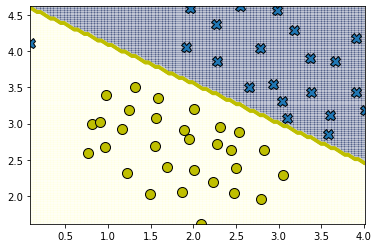

In [115]:
visualizeBoundary(X_1, y_1, model)


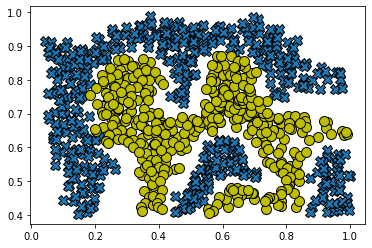

In [117]:
data = loadmat(os.path.join('Data', 'ex6data2.mat'))
X, y = data['X'], data['y'][:, 0]

# Plot training data
plotData(X, y)

C:\Users\Hamza\anaconda3\envs\PY37\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


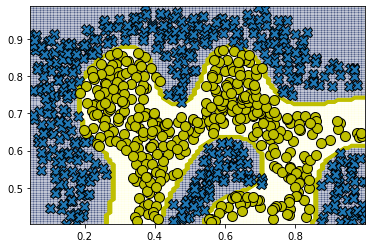

In [128]:
C = 1
sigma = 0.1

model= svmTrain(X, y, C, gaussianKernel, args=(sigma,))
visualizeBoundary(X, y, model)